In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys

sys.path.append('/content/gdrive/My Drive/Colab Notebooks/ECE_Project')


In [0]:
import CNN_Lib
import CNN_BuildingBlock_Lib as BB
import CombinationModel as ComboCNN
import numpy as np 
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import random
import pdb
import copy
import matplotlib.pyplot as plt


In [0]:
dir = '/content/gdrive/My Drive/Colab Notebooks/ECE_Project'
X_test = np.load(dir + '/X_test.npy')
y_test = np.load(dir + '/y_test.npy')
person_train_valid = np.load(dir + '/person_train_valid.npy')
X_train_valid = np.load(dir + '/X_train_valid.npy')
y_train_valid = np.load(dir + '/y_train_valid.npy')
person_test = np.load(dir + '/person_test.npy')

In [0]:
#### Set the Training Mode.... One / All
mode = "All"

if mode == "All":
  pass
elif mode == "One":
  masktrain = np.where(person_train_valid == 1)
  X_train_valid = X_train_valid[masktrain[0]]
  y_train_valid = y_train_valid[masktrain[0]]

  masktest = np.where(person_test == 1)
  X_test = X_test[masktest[0]]
  y_test = y_test[masktest[0]]

In [41]:
### Verify Data Shapes...

print ('Training/Valid data shape: {}' .format(X_train_valid.shape))
print ('Test data shape: {}' .format(X_test.shape))
print ('Training/Valid target shape: {}' .format(y_train_valid.shape))
print ('Test target shape: {}' .format(y_test.shape))
print ('Person train/valid shape: {}' .format(person_train_valid.shape))
print ('Person test shape: {}' .format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [0]:
#transform data into torch-readable data types
#2115 number of trials from 9 people
#four possible classes of outputs

Xtrain = torch.from_numpy(X_train_valid)
Ytrain = torch.from_numpy(y_train_valid)
Xtest = torch.from_numpy(X_test)
Ytest = torch.from_numpy(y_test)



In [0]:
def map_to_class(input_labels):
  mask1 = (input_labels == 769)*0
  mask2 = (input_labels == 770)*1
  mask3 = (input_labels == 771)*2
  mask4 = (input_labels == 772)*3

  return (mask1 + mask2 + mask3 + mask4)

In [0]:
def plot_val_train(validation_acc, train_acc, k, its):
  f = plt.figure(figsize=(15, 10))
  if mode == "All":
    plt.title(f"Model Performance while Validating on K-Fold {k}")
  elif mode == "One":
    plt.title(f"Model Performance While Training on One Person {k}")

  plt.plot(validation_acc, 'g-', label='validation')
  plt.plot(train_acc, 'b-', label='training')
  plt.xticks(np.arange(0, its, step=200))  # Set label locations.
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy (%)")
  plt.legend()
  return f


In [0]:
#perhaps normalizing noisy data will help learning?
#tried first with L2, improved slightly...
def normalize(x):
  return F.normalize(x, p=1, dim=2)


In [0]:
def smooth(x,window_size=11,window='hanning'):
  """
    Adapted from SciPy Cookbook
    Window can be: ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
  """
  smoothed = np.r_[x[window_size-1:0:-1], x, x[-2:-window_size-1:-1]]
  
  #moving average
  if window == 'flat':
      w = np.ones(window_len,'d')
  else:
      w = eval('np.' + window + '(window_size)')

  smoothed = np.convolve(w/w.sum(), smoothed, mode='valid')
  if len(x) < len(smoothed):
    dif = abs(len(x) - len(smoothed))//2
    smoothed = smoothed[dif:len(smoothed)-dif]
  return smoothed

In [0]:
def augment_data(data_set, window_size, window):
  out = np.zeros_like(data_set)
  out = torch.from_numpy(out)
  for i in range(data_set.shape[0]):
    for j in range(data_set.shape[1]):
      out[i,j,:] = torch.from_numpy(smooth(data_set[i,j,:], window_size, window))
  return out

In [48]:
######### AUGMENT DATASET
Smoothed = augment_data(X_train_valid, 11,'hanning')
Normalized = normalize(Xtrain)

idx1 = np.arange(X_train_valid.shape[0]//2)
np.random.shuffle(idx1)

idx2 = np.arange(X_train_valid.shape[0]//2)
np.random.shuffle(idx2)

OutX = torch.cat((Xtrain, Smoothed[idx1], Normalized[idx2]),0)
OutY = torch.cat((Ytrain, Ytrain[idx1], Ytrain[idx2]),0)
print(OutX.size())

Xtrain = OutX
Ytrain = OutY

torch.Size([4229, 22, 1000])


Parameters Optimized While Training Across ALL subjects:

In [49]:

Trials, InputDim, SeqDim = X_train_valid.shape
num_features = InputDim
Tests = y_test.shape

#-----CNN tweak here----#
num_filters = [64, 64, 32] #64, 32, 32 up to 70% V, and 64, 64, 32 plateud at ~61-63% after Epoch 1 then increased to 67% | 72 max
batch_size = 60   #smaller batch sizes (less than 50) offer a regularization effect | must be less than 423 bc we are using kfold validation of 5
num_classes = 4
L2 = 0.22 #higher than 0.25 and the validation doesnt reach 70
cnnfilter_stride = [2, 1, 1] #big filter stride makes training to acceptable validation take longer. 
cnnfilter_size = [10, 3, 3] #smaller filter size appears to make higher validation from the beginning. lower than 2 is pretty bad?
cnn_padding = [1, 1, 1]
use_bias = [False, True, False]
use_maxpool = [True, True, True] #not using it makes the model overfit
pool_size = [5, 3, 2]
pool_stride = [2, 1, 1]
use_batchnorm = [True, True, True]
eps = [1e-4, 1e-4, 1e-4]
momentum = [0.3, 0.8, 0.5]
affine = [False, False, False]
dropout = [0.13, 0.21, 0.1, 0.55]


#-----OPTIM tweak here----#
learning_rate = 0.0001 #0 we trained faster with this vs 0.0001 
#initialize the network within the kfold loop
combo_model = ComboCNN.CombinationModel(InputDim, SeqDim, num_filters, cnnfilter_size, 
                                            cnnfilter_stride, cnn_padding, use_bias, 
                                            num_classes, use_maxpool, pool_size, pool_stride, 
                                            use_batchnorm, eps, momentum, affine, dropout)
combo_model.to('cuda:0') #--- activate the GPU

CombinationModel(
  (CNN_Block1): EEG_CNN_BuildingBlock(
    (CNN): Conv1d(22, 64, kernel_size=(10,), stride=(2,), padding=(1,), bias=False)
    (RELU): ReLU()
    (BatchNorm): BatchNorm1d(64, eps=0.0001, momentum=0.3, affine=False, track_running_stats=True)
    (DropOut): Dropout(p=0.13, inplace=False)
    (MaxPool): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (CNN_Block2): EEG_CNN_BuildingBlock(
    (CNN): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (RELU): ReLU()
    (BatchNorm): BatchNorm1d(64, eps=0.0001, momentum=0.8, affine=False, track_running_stats=True)
    (DropOut): Dropout(p=0.21, inplace=False)
    (MaxPool): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (CNN_Block3): EEG_CNN(
    (CNN): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (RELU): ReLU()
    (BatchNorm): BatchNorm1d(32, eps=0.0001, momentum=0.5, affine=False, track_running_stats=True)
    (Dr

Parameters Optimized While Training Across Subject 1

In [0]:

Trials, InputDim, SeqDim = X_train_valid.shape
num_features = InputDim
Tests = y_test.shape

#-----CNN tweak here----#
num_filters = [64, 32, 32] #smaller is better for this network, since we don't have much data
batch_size = 60   
num_classes = 4
L2 = 0.45 
cnnfilter_stride = [2, 1, 1] #big filter stride makes training to acceptable validation take longer. 
cnnfilter_size = [10, 3, 3] #smaller filter size appears to make higher validation from the beginning. lower than 2 is pretty bad?
cnn_padding = [1, 1, 1]
use_bias = [False, True, False]
use_maxpool = [True, True, True] #not using it makes the model overfit
pool_size = [5, 3, 2]
pool_stride = [2, 1, 1]
use_batchnorm = [True, True, True]
eps = [1e-4, 1e-4, 1e-4]
momentum = [0.3, 0.8, 0.5]
affine = [False, False, False]
dropout = [0.13, 0.21, 0.4, 0.55]


#-----OPTIM tweak here----#
learning_rate = 0.00005

In [0]:
########## CHOOSE LOSS  ###########
loss = torch.nn.CrossEntropyLoss()

######### CHOOSE OPTIMIZER ########
#optim = torch.optim.Adam(combo_model.parameters(), lr=learning_rate, weight_decay=L2)
#optim = torch.optim.Adadelta(combo_model.parameters()) << does worse than Adam, we overfit so much 

...... Training for Epoch 0 ......
______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______


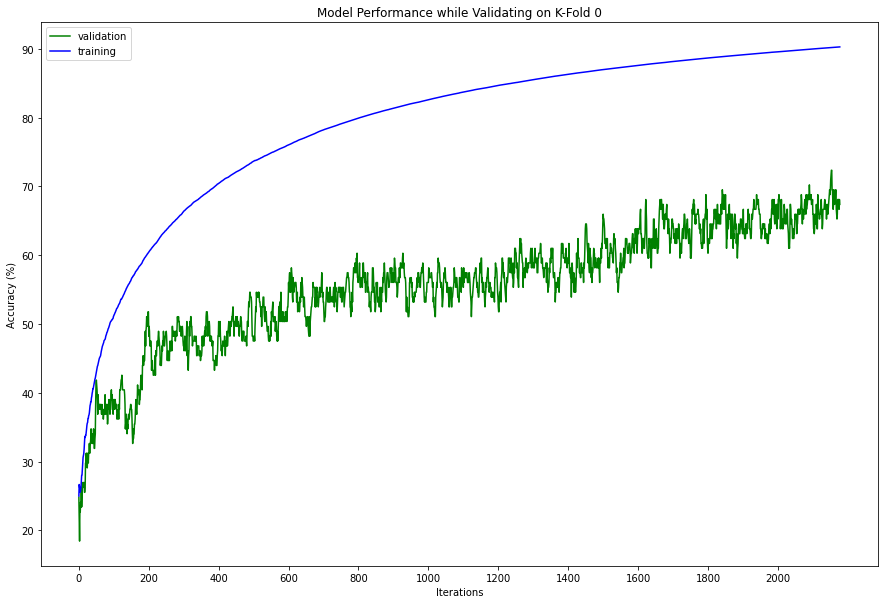

______ Training for k-folds [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14] ______


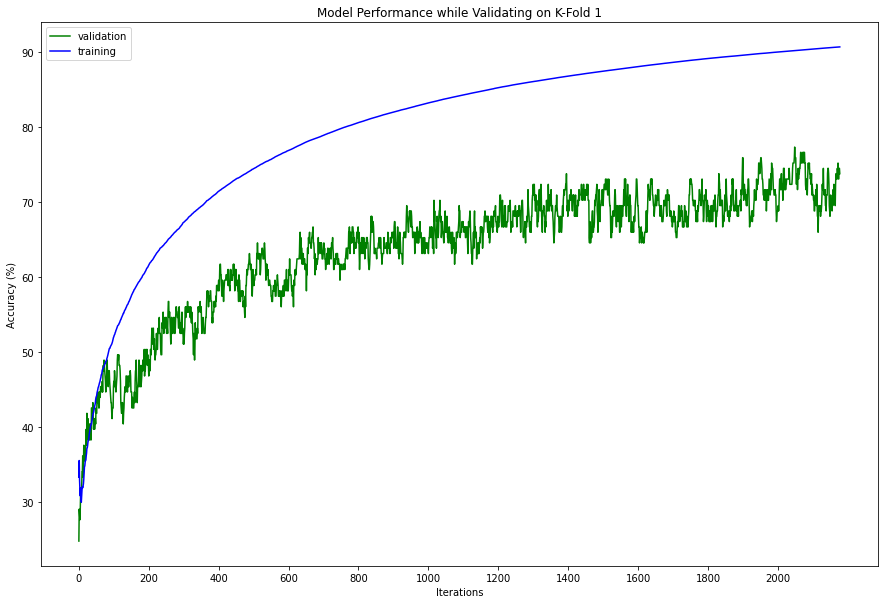

______ Training for k-folds [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14] ______


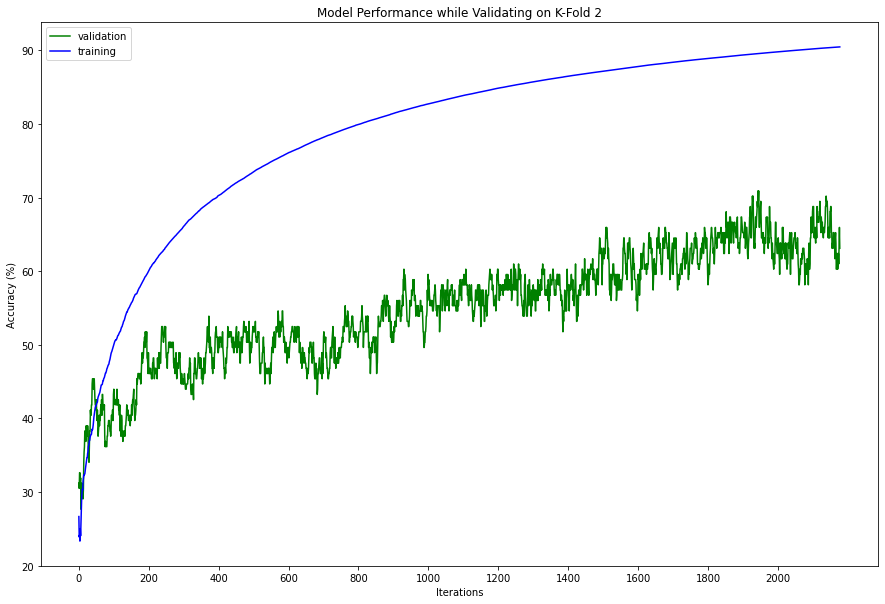

______ Training for k-folds [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14] ______


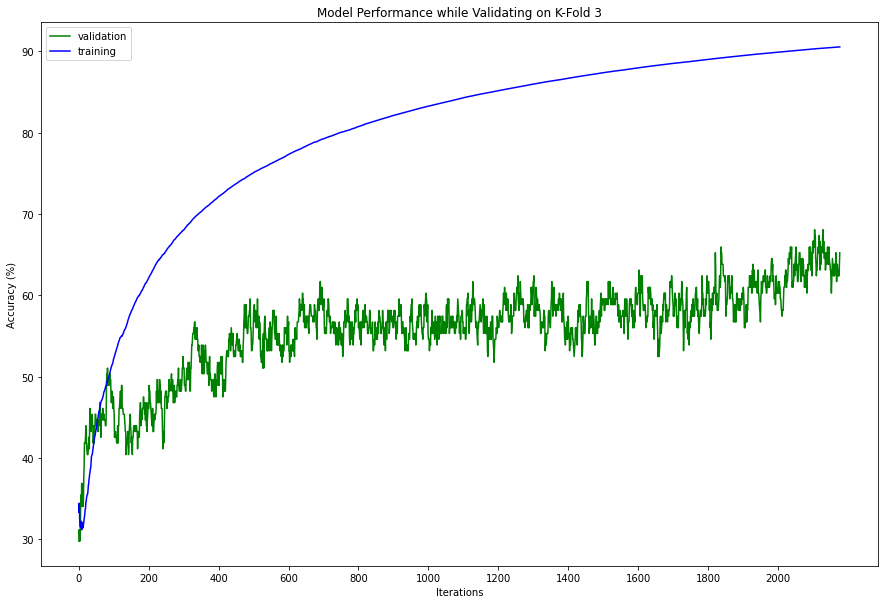

______ Training for k-folds [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14] ______


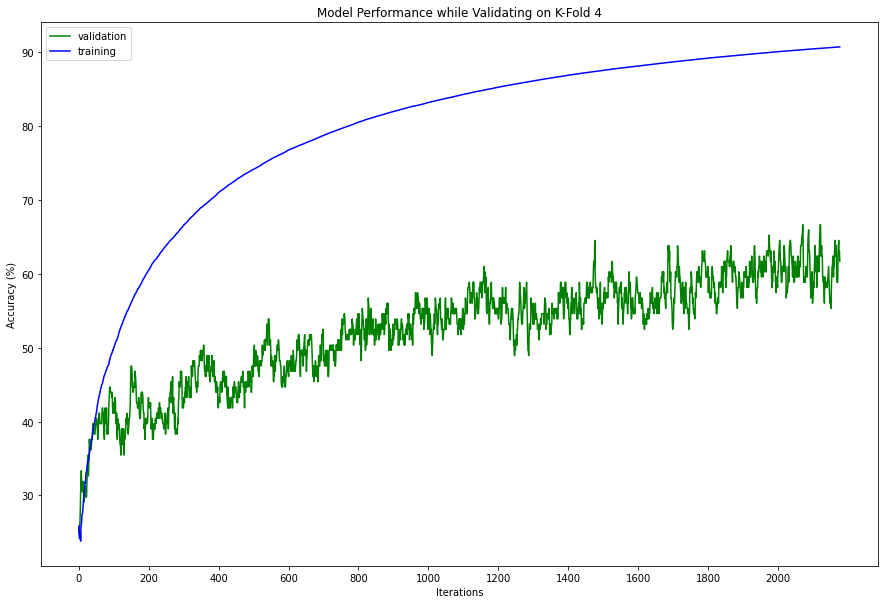

______ Training for k-folds [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14] ______


KeyboardInterrupt: ignored

In [50]:
######## TRAIN IT ######## .... got up to 58% but huge range. from 30 was the low.
#------ With Early Stopping AND K-Fold Validation -----#
epochs = 1
kfolds = 15
iterations = 2200
iter_ = 0
validate_fold = 0
SEED = 2000

stop_now = False
loss_store = [[] for i in range(kfolds)]
validation_store = [[] for i in range(kfolds)]
training_store = [[] for i in range(kfolds)]
network_store = [[] for i in range(kfolds)]
model_store = []


#k fold validation here
np.random.seed(random.randint(1,SEED))
fold_size = int(Trials/kfolds)
idx = np.arange(Trials)
np.random.shuffle(idx)
Xtrain_Shuffled = Xtrain[idx]
Ytrain_Shuffled = Ytrain[idx]

FoldsX = Xtrain_Shuffled.split(fold_size)
FoldsY = Ytrain_Shuffled.split(fold_size)

for epoch in range(epochs):
  if stop_now:
    break

  print(f"...... Training for Epoch {epoch} ......")
  for k in range(kfolds): 
    train_correct = 0
    train_total = 0

    #total = 0
    #correct = 0

    #create training folds by excluding validate fold
    train_folds = list(range(kfolds))
    del train_folds[validate_fold]
    train_folds = np.array(train_folds)
    TrainX = torch.cat([FoldsX[f] for f in train_folds]) 
    TrainY = torch.cat([FoldsY[f] for f in train_folds])

    #create validate fold
    ValidateX = FoldsX[validate_fold]
    ValidateY = FoldsY[validate_fold]

    #initialize the network within the kfold loop
    combo_model = ComboCNN.CombinationModel(InputDim, SeqDim, num_filters, cnnfilter_size, 
                                            cnnfilter_stride, cnn_padding, use_bias, 
                                            num_classes, use_maxpool, pool_size, pool_stride, 
                                            use_batchnorm, eps, momentum, affine, dropout)
    combo_model.to('cuda:0') #--- activate the GPU
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(combo_model.parameters(), lr=learning_rate, weight_decay=L2) 

    print(f"______ Training for k-folds {train_folds} ______")
    for i in range(iterations):
      #do the batches
      idx = np.arange(TrainX.size(0))
      np.random.shuffle(idx)
      idx = idx[0:batch_size]

      #process the input data
      xtrain = TrainX[idx].view(batch_size, InputDim, SeqDim)
      xtrain = xtrain.to('cuda:0').requires_grad_()
      ytrain = TrainY[idx]

      #put the model in training mode
      combo_model.train(True)

      #forward pass
      optim.zero_grad()
      outFC = combo_model.forward(xtrain.float())
  
      #map to classes
      classes = map_to_class(ytrain.long())
      classes = classes.to('cuda:0')

      #backward pass (gradient calculation)
      probs = loss(outFC, classes)
      probs.backward()

      #update weights
      optim.step()

      #update iter counter
      iter_+=1

      #calculate training accuracy
      #train_pred = F.softmax(outFC, 1)
      values, predicted = torch.max(outFC, 1)
      train_correct += (1*(predicted == classes)).sum()
      train_total += float(classes.size(0))

      if i % 100:
        #print(f"______ Validating for k-fold {k} ______")
        combo_model.eval()
        
        #process the input data
        idx = np.random.randint(0, Tests, size=batch_size)
        xvalid = ValidateX.view(-1, InputDim, SeqDim)
        xvalid = xvalid.to('cuda:0')
        yvalid = ValidateY

        #forward prop
        predict = combo_model(xvalid.float())
        
        #predict
        #pred = F.softmax(predict, 1)
        values, predicted_classes = torch.max(predict, 1)
        expected_classes = map_to_class(yvalid)
        correct = (1*(predicted_classes == expected_classes.to('cuda:0'))).sum()
        total =float(predicted_classes.size(0))

        #evaluate
        validation_accuracy = 100*(correct/total)
        training_accuracy = 100*(train_correct/train_total)

        #print(f"correct: {correct}, total: {total}")
        #print(f"prediction: {predicted_classes}\nexpected_classes: {expected_classes}")
        #print(f"Iteration: {iter_}, Loss: {probs.item()}, Validation Accuracy: {validation_accuracy}%, Training Accuracy: {training_accuracy}%\n")  

        #store info for graphing later
        validation_store[k].append(validation_accuracy.item())
        loss_store[k].append(probs.item())
        training_store[k].append(training_accuracy.item())
        
        #--- Early stopping criterion here --- #
        #if k > 0:
          #if abs(loss_store[k][len(loss_store[k])-2] - loss_store[k][len(loss_store[k])-1]) < 1e-3:
            #print("Early Stopping!")
            #stop_now = True
            #break
    
    #plot things
    plot = plot_val_train(validation_store[k], training_store[k], k, iterations)    
    plt.show(plot)

    #store the model
    model_store.append(copy.deepcopy(combo_model))

    if mode == "All":
      #iterate the validate fold
      validate_fold +=1
    elif mode == "One":
      break
    

    

In [57]:
#Find Best Model and Test It
best_ind = 3
best_model = None
#if mode == "All":
#  best_ind = np.argmax(np.max(np.array(validation_store), 1))
#elif mode == "One":
#  best_ind = 0
  
best_model = model_store[best_ind]

print(f"______ Evaluating On Test Data ______")
best_model.eval()

total = 0
correct = 0

#process the input data
xtest = Xtest.view(-1, InputDim, SeqDim)
xtest = xtest.to('cuda:0')
ytest = Ytest

#forward prop
predict = best_model(xtest.float())

#predict
values, predicted_classes = torch.max(predict, 1)
expected_classes = map_to_class(ytest)        
correct += (1*(predicted_classes == expected_classes.to('cuda:0'))).sum()
total +=float(predicted_classes.size(0))

#evaluate
test_accuracy = 100*(correct/total)

print(f"correct: {correct}, total: {total}")
print(f"Testing Accuracy: {test_accuracy}%")  
print(f"Vaidation Accuracy: {max(validation_store[best_ind])}")
print(f"Training Accuracy: {max(training_store[best_ind])}")

______ Evaluating On Test Data ______
correct: 291, total: 443.0
Testing Accuracy: 65.68849182128906%
Vaidation Accuracy: 68.0851058959961
Training Accuracy: 90.55908966064453


In [0]:
best_ind

9

Now, we will try to evaluate how the dataset's length affects the model's prediction accuracy

In [0]:
time_lengths = [200, 300, 400, 500, 600, 700, 800, 900]

epochs = 1
kfolds = 15
iterations = 2200
iter_ = 0
validate_fold = 0
SEED = 2000

stop_now = False
loss_store = [[] for i in range(len(time_lengths))]
validation_store = [[] for i in range(len(time_lengths))]
training_store = [[] for i in range(len(time_lengths))]
network_store = [[] for i in range(len(time_lengths))]
model_store = []


#k fold validation here
np.random.seed(random.randint(1,SEED))
fold_size = int(Trials/kfolds)
idx = np.arange(Trials)
np.random.shuffle(idx)
Xtrain_Shuffled = Xtrain[idx]
Ytrain_Shuffled = Ytrain[idx]

FoldsX = Xtrain_Shuffled.split(fold_size)
FoldsY = Ytrain_Shuffled.split(fold_size)

#create training folds by excluding validate fold
train_folds = list(range(kfolds))
del train_folds[validate_fold]
train_folds = np.array(train_folds)
TrainX_Combined = torch.cat([FoldsX[f] for f in train_folds])
TrainY = torch.cat([FoldsY[f] for f in train_folds])

#create validate fold
ValidateX_Combined = FoldsX[validate_fold]
ValidateY = FoldsY[validate_fold]

for ind, t in enumerate(time_lengths):    
    train_correct = 0
    train_total = 0

    #mod dim of time series len
    SeqDim = t
    TrainX = TrainX_Combined[:,:,0:t]
    ValidateX = ValidateX_Combined[:,:,0:t]

    #initialize the network within the kfold loop
    combo_model = ComboCNN.CombinationModel(InputDim, SeqDim, num_filters, cnnfilter_size, 
                                            cnnfilter_stride, cnn_padding, use_bias, 
                                            num_classes, use_maxpool, pool_size, pool_stride, 
                                            use_batchnorm, eps, momentum, affine, dropout)
    combo_model.to('cuda:0') #--- activate the GPU
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(combo_model.parameters(), lr=learning_rate, weight_decay=L2) 

    print(f"______ Training for k-folds {train_folds} ______")
    for i in range(iterations):
      #do the batches
      idx = np.arange(TrainX.size(0))
      np.random.shuffle(idx)
      idx = idx[0:batch_size]

      #process the input data
      xtrain = TrainX[idx].view(batch_size, InputDim, SeqDim)
      xtrain = xtrain.to('cuda:0').requires_grad_()
      ytrain = TrainY[idx]

      #put the model in training mode
      combo_model.train(True)

      #forward pass
      optim.zero_grad()
      outFC = combo_model.forward(xtrain.float())
  
      #map to classes
      classes = map_to_class(ytrain.long())
      classes = classes.to('cuda:0')

      #backward pass (gradient calculation)
      probs = loss(outFC, classes)
      probs.backward()

      #update weights
      optim.step()

      #update iter counter
      iter_+=1

      #calculate training accuracy
      #train_pred = F.softmax(outFC, 1)
      values, predicted = torch.max(outFC, 1)
      train_correct += (1*(predicted == classes)).sum()
      train_total += float(classes.size(0))

      if i % 100:
        #print(f"______ Validating for k-fold {k} ______")
        combo_model.eval()
        
        #process the input data
        idx = np.random.randint(0, Tests, size=batch_size)
        xvalid = ValidateX.view(-1, InputDim, SeqDim)
        xvalid = xvalid.to('cuda:0')
        yvalid = ValidateY

        #forward prop
        predict = combo_model(xvalid.float())
        
        #predict
        values, predicted_classes = torch.max(predict, 1)
        expected_classes = map_to_class(yvalid)
        correct = (1*(predicted_classes == expected_classes.to('cuda:0'))).sum()
        total =float(predicted_classes.size(0))

        #evaluate
        validation_accuracy = 100*(correct/total)
        training_accuracy = 100*(train_correct/train_total)

        #print(f"correct: {correct}, total: {total}")
        #print(f"prediction: {predicted_classes}\nexpected_classes: {expected_classes}")
        #print(f"Iteration: {iter_}, Loss: {probs.item()}, Validation Accuracy: {validation_accuracy}%, Training Accuracy: {training_accuracy}%\n")  

        #store info for graphing later
        validation_store[ind].append(validation_accuracy.item())
        loss_store[ind].append(probs.item())
        training_store[ind].append(training_accuracy.item())
        

    #store the model
    model_store.append(copy.deepcopy(combo_model))

    

    


______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______
______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______
______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______
______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______
______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______
______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______
______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______
______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______


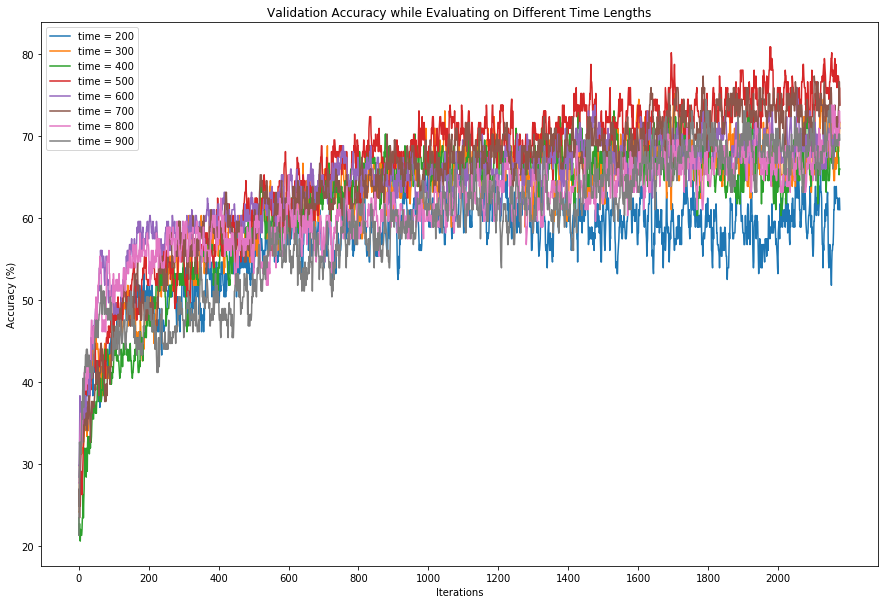

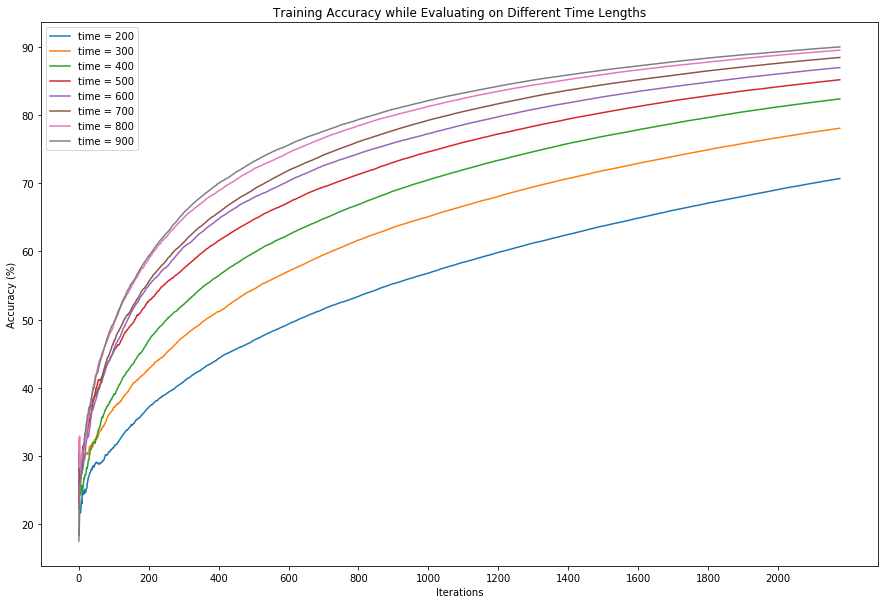

In [0]:
#Time series evaluation print out

F1 = plt.figure(figsize=(15, 10))
plt.title(f"Validation Accuracy while Evaluating on Different Time Lengths")
for i in range(len(model_store)):
  plt.plot(validation_store[i], '-', label=f'time = {time_lengths[i]}')

plt.xticks(np.arange(0, iterations, step=200))  # Set label locations.
plt.xlabel("Iterations")
plt.ylabel("Accuracy (%)")
plt.legend()

### Plot Training
F2 = plt.figure(figsize=(15, 10))
plt.title(f"Training Accuracy while Evaluating on Different Time Lengths")
for i in range(len(model_store)):
  plt.plot(training_store[i], '-', label=f'time = {time_lengths[i]}')

plt.xticks(np.arange(0, iterations, step=200))  # Set label locations.
plt.xlabel("Iterations")
plt.ylabel("Accuracy (%)")
plt.legend()

Knowing now that length 500 provides higher validation and less overfit, let's evaluate it on the test data and see what we get

In [0]:
#Find Best Model and Test It
best_model = model_store[3]

print(f"______ Evaluating On Test Data ______")
best_model.eval()

total = 0
correct = 0

#process the input data
xtest = Xtest[:,:,0:500].view(-1, InputDim, 500)
xtest = xtest.to('cuda:0')
ytest = Ytest

#forward prop
predict = best_model(xtest.float())

#predict
values, predicted_classes = torch.max(predict, 1)
expected_classes = map_to_class(ytest)        
correct += (1*(predicted_classes == expected_classes.to('cuda:0'))).sum()
total +=float(predicted_classes.size(0))

#evaluate
test_accuracy = 100*(correct/total)

print(f"correct: {correct}, total: {total}")
print(f"Testing Accuracy: {test_accuracy}%")  


______ Evaluating On Test Data ______
correct: 288, total: 443.0
Testing Accuracy: 65.01128387451172%
